### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
#from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


#from keras.utils import plot_model


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.5.0


In [2]:
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor
import joblib

In [3]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

In [4]:
from tqdm import tqdm
import cv2
import re
from tensorflow.keras.layers import MaxPooling2D

### Data Pre-Processing

In [5]:
WORK_DIR = './dataset/'

CLASSES = [ 'CN','AD']

IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)

### Make DataFrame

In [6]:
CN_number = len(os.listdir("E:/test_dataset_hippocampus/CN"))
AD_number = len(os.listdir("E:/test_dataset_hippocampus/AD"))

In [7]:
images = [[] for i in range(AD_number)]  #6518
labels = [[] for i in range(AD_number)]
# for subfolder in tqdm(os.listdir("E:/dataset_CN_AD")):
#     subfolder_path = os.path.join("E:/dataset_CN_AD", subfolder)  #AD CN MCI folder
for ind , folder in enumerate(os.listdir("E:/test_dataset_hippocampus/AD")):    #folder = 0,1,2....,2294
    subfolder_path2=os.path.join("E:/test_dataset_hippocampus/AD",folder)   
    for image_filename in os.listdir(subfolder_path2):    #ex :0的所有切片圖
        image_path = os.path.join(subfolder_path2, image_filename)
        images[ind].append(image_path)
    labels[ind].append('AD')
df = pd.DataFrame({'image': images, 'label': labels})
df

,image,label
0,[E:/test_dataset_hippocampus/AD\3178\slide_317...,[AD]
1,[E:/test_dataset_hippocampus/AD\3179\slide_317...,[AD]
2,[E:/test_dataset_hippocampus/AD\3197\slide_319...,[AD]
3,[E:/test_dataset_hippocampus/AD\3198\slide_319...,[AD]
4,[E:/test_dataset_hippocampus/AD\10\slide_10_0....,[AD]
...,...,...
595,[E:/test_dataset_hippocampus/AD\3164\slide_316...,[AD]
596,[E:/test_dataset_hippocampus/AD\3165\slide_316...,[AD]
597,[E:/test_dataset_hippocampus/AD\3175\slide_317...,[AD]
598,[E:/test_dataset_hippocampus/AD\3176\slide_317...,[AD]


In [8]:
images = [[] for i in range(CN_number)]  #6518
labels = [[] for i in range(CN_number)]

# for subfolder in tqdm(os.listdir("E:/dataset_CN_AD")):
#     subfolder_path = os.path.join("E:/dataset_CN_AD", subfolder)  #AD CN MCI folder
for ind , folder in enumerate(os.listdir("E:/test_dataset_hippocampus/CN")):    #folder = 0,1,2....,2294
    subfolder_path2=os.path.join("E:/test_dataset_hippocampus/CN",folder)   
    for image_filename in os.listdir(subfolder_path2):    #ex :0的所有切片圖
        image_path = os.path.join(subfolder_path2, image_filename)
        images[ind].append(image_path)
    labels[ind].append('CN')
df2 = pd.DataFrame({'image': images, 'label': labels})
df2

,image,label
0,[E:/test_dataset_hippocampus/CN\1939\slide_193...,[CN]
1,[E:/test_dataset_hippocampus/CN\0\slide_0_0.jp...,[CN]
2,[E:/test_dataset_hippocampus/CN\1\slide_1_0.jp...,[CN]
3,[E:/test_dataset_hippocampus/CN\2\slide_2_0.jp...,[CN]
4,[E:/test_dataset_hippocampus/CN\3\slide_3_0.jp...,[CN]
...,...,...
595,[E:/test_dataset_hippocampus/CN\1910\slide_191...,[CN]
596,[E:/test_dataset_hippocampus/CN\1911\slide_191...,[CN]
597,[E:/test_dataset_hippocampus/CN\1912\slide_191...,[CN]
598,[E:/test_dataset_hippocampus/CN\1913\slide_191...,[CN]


In [9]:
df = pd.concat([df, df2],ignore_index=True)

In [10]:
df

,image,label
0,[E:/test_dataset_hippocampus/AD\3178\slide_317...,[AD]
1,[E:/test_dataset_hippocampus/AD\3179\slide_317...,[AD]
2,[E:/test_dataset_hippocampus/AD\3197\slide_319...,[AD]
3,[E:/test_dataset_hippocampus/AD\3198\slide_319...,[AD]
4,[E:/test_dataset_hippocampus/AD\10\slide_10_0....,[AD]
...,...,...
1195,[E:/test_dataset_hippocampus/CN\1910\slide_191...,[CN]
1196,[E:/test_dataset_hippocampus/CN\1911\slide_191...,[CN]
1197,[E:/test_dataset_hippocampus/CN\1912\slide_191...,[CN]
1198,[E:/test_dataset_hippocampus/CN\1913\slide_191...,[CN]


### 去掉label的list

In [11]:
for ind , label in enumerate(df['label']):
    df['label'][ind] = label[0]


df


,image,label
0,[E:/test_dataset_hippocampus/AD\3178\slide_317...,AD
1,[E:/test_dataset_hippocampus/AD\3179\slide_317...,AD
2,[E:/test_dataset_hippocampus/AD\3197\slide_319...,AD
3,[E:/test_dataset_hippocampus/AD\3198\slide_319...,AD
4,[E:/test_dataset_hippocampus/AD\10\slide_10_0....,AD
...,...,...
1195,[E:/test_dataset_hippocampus/CN\1910\slide_191...,CN
1196,[E:/test_dataset_hippocampus/CN\1911\slide_191...,CN
1197,[E:/test_dataset_hippocampus/CN\1912\slide_191...,CN
1198,[E:/test_dataset_hippocampus/CN\1913\slide_191...,CN


3690 1198


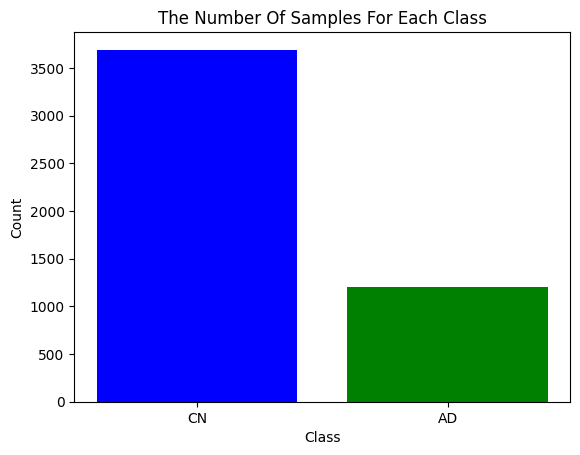

In [12]:
# 使用 value_counts() 獲取各類標籤的計數
counts = df['label'][:].value_counts()

# 從 counts 中獲取 'CN' 和 'MCI' 的計數，如果不存在則返回0
a = counts.get('CN', 0)

c = counts.get('AD', 0)  # 如果你只關心 'CN', 'MCI' 和 'Other'

# 如果你想計算不是 'CN' 或 'MCI' 的所有其他類別
# 你可以將所有值加起來，然後減去 'CN' 和 'MCI' 的總和
#c = counts.sum() - (a + b)

# 輸出結果
print(a, c)
labels = ['CN', 'AD']
counts = [a, c]

# 使用条形图展示计数
plt.bar(labels, counts, color=['blue', 'green'])

# 添加标题和轴标签
plt.title('The Number Of Samples For Each Class')
plt.xlabel('Class')
plt.ylabel('Count')

# 显示图表
plt.show()

### 視覺化

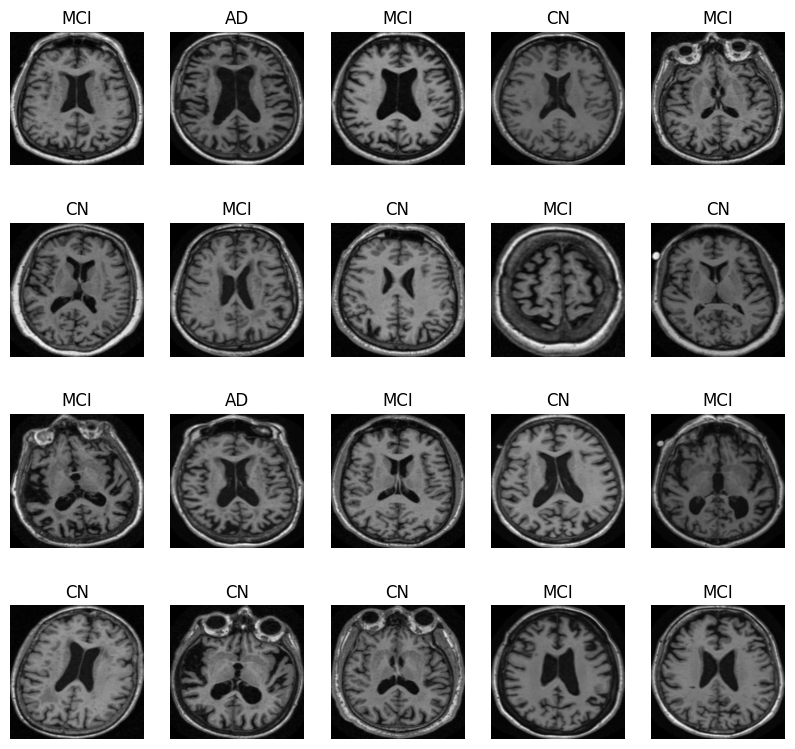

In [9]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(df.image[i][20])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=12)

### 排序切片

In [13]:
for ind , data in enumerate(df['image']):
# 排序函數，用正則表達式從每個路徑中提取數字並按該數字排序
    #df['image'][ind] = sorted(data, key=lambda x: int(re.search(r"slide_{}_(\d+)\.jpg".format(ind), x).group(1)))
    df['image'][ind] = sorted(data, key=lambda x: int(re.search(r"\d+(?=\.\w+$)", x).group()))

# # 輸出排序後的列表
# for path in sorted_paths:
#     print(path)

### 把多張切片取20張，疊在一起  (改成取三張 0.65 0.7 0.75)

In [12]:
# stack_images = [[] for i in range(len(df['image']))]
# for ind, data in enumerate(df['image']):
#     center = int(len(data) * 0.5)
#     for slice_ind ,slice in enumerate(data):
#         if center-5 < slice_ind <= center+15:
#             a = cv2.imread(slice)
#             gray_image = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
#             img_tensor = tf.convert_to_tensor(gray_image ,dtype=tf.uint8)

#             stack_images[ind].append(img_tensor)
#         df['image'][ind] = tf.stack(stack_images[ind])
#     #print(ind)

In [13]:
#取三張的CODE
stack_images = [[] for i in range(len(df['image']))]
for ind, data in enumerate(df['image']):
    
    for slice_ind ,slice in enumerate(data):
        if slice_ind == int(len(data) * 0.5) or slice_ind == int(len(data) * 0.7) or slice_ind == int(len(data) * 0.9):
            a = cv2.imread(slice)
            gray_image = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
            img_tensor = tf.convert_to_tensor(gray_image ,dtype=tf.uint8)

            stack_images[ind].append(img_tensor)
        df['image'][ind] = tf.stack(stack_images[ind])
    #print(ind)

In [14]:
df['image'][0].shape

TensorShape([3, 256, 256])

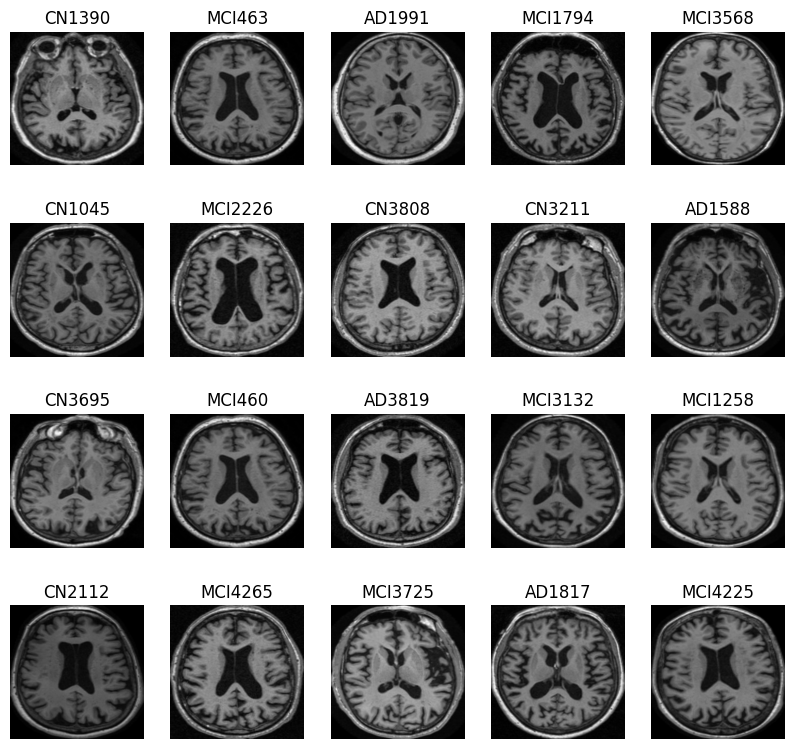

In [15]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=df['image'][i][1]
    #print(img.shape)
    #img=cv2.resize(img,(224,224))
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img,cmap = 'gray')
    plt.axis('off')
    plt.title(df.label[i]+str(i),fontsize=12)

In [17]:
# if not os.path.exists('stack_images_nocrop_slides'):
#         os.makedirs('stack_images_nocrop_slides')

In [19]:

# for idx, tensor in enumerate(df['image']):
#     #if idx >2293:
#     if tensor is not None:
#         np.save(f'./stack_images_nocrop_slides/image_stack_{idx}.npy', tensor.numpy())
#     else:
#         print(f"Notice: No data to save for index {idx}.")
        

In [82]:
# for i in range(len(df['image'])):
#     df['image'][i] = os.path.join('./stack_images' + '/image_stack_{}.npy'.format(i) )

In [83]:
#df 

,image,label
0,./stack_images/image_stack_0.npy,[CN]
1,./stack_images/image_stack_1.npy,[CN]
2,./stack_images/image_stack_2.npy,[CN]
3,./stack_images/image_stack_3.npy,[CN]
4,./stack_images/image_stack_4.npy,[CN]
...,...,...
2289,./stack_images/image_stack_2289.npy,[CN]
2290,./stack_images/image_stack_2290.npy,[CN]
2291,./stack_images/image_stack_2291.npy,[MCI]
2292,./stack_images/image_stack_2292.npy,[MCI]


In [14]:
type(df['image'][0])

list

In [46]:
stack_array = []
path = 'D:/bigwind/test_dataset_hippocampus'
for ind , data in enumerate(os.listdir(path)):
    path2 = os.path.join( 'D:/bigwind/test_dataset_hippocampus' ,  data)
    
    array = np.load(path2)

    stack_array.append(array)

In [ ]:
stack_array_CN = []
path = "E:/stack_images_ventricle_new_CN"
for ind , data in enumerate(os.listdir(path)):
    path2 = os.path.join( "E:/stack_images_ventricle_new_CN" ,  data)
    
    array = np.load(path2)

    stack_array_CN.append(array)

In [37]:
stack_array_AD = []
path = "E:/stack_images_ventricle_new_AD"
for ind , data in enumerate(os.listdir(path)):
    path2 = os.path.join( "E:/stack_images_ventricle_new_AD" ,  data)
    
    array = np.load(path2)

    stack_array_AD.append(array)

In [47]:
stack_array[0].shape

(3, 256, 256)

### Normalize

In [48]:
for ind , data in enumerate(stack_array):
    stack_array[ind] = data / data.max()


In [39]:
for ind , data in enumerate(stack_array_AD):
    stack_array_AD[ind] = data / data.max()

### Reshape / permute

In [49]:
for ind , array in enumerate(stack_array):

    stack_array[ind] = np.array(tf.transpose(array,perm=[1,2,0]))

In [41]:
for ind , array in enumerate(stack_array_AD):

    stack_array_AD[ind] = np.array(tf.transpose(array,perm=[1,2,0]))

In [50]:
stack_array[0].shape

(256, 256, 3)

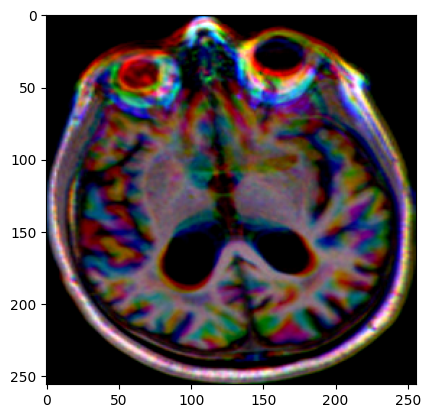

In [20]:
plt.imshow(stack_array[2],cmap='gray')

In [51]:
type(stack_array)

list

In [42]:
stack_array = stack_array + stack_array_AD

In [52]:
stack_array = np.array(stack_array)

In [53]:
stack_array.shape

(1200, 256, 256, 3)

In [45]:
label_AD = ['AD' for i in range(2038)]

In [54]:
labels2=[]
for i in df['label']:
    labels2.append(i)

In [47]:
labels2 = labels2 + label_AD

In [55]:
len(labels2)

1200

In [56]:


# 标签到数字的映射字典
label_map = {'CN': [1,0], 'AD': [0,1]}

# 将标签列表替换为数字
labels_as_numbers = [np.array(label_map[label]) for label in labels2]

print(len(labels_as_numbers))

1200


In [57]:
train_dataset = stack_array

#test_examples = stack_array[1835:]
#test_labels = labels_as_numbers[1835:]

In [58]:
train_dataset.shape

(1200, 256, 256, 3)

In [59]:
train_labels_dataset = labels_as_numbers

In [60]:
train_labels_dataset[0].shape

(2,)

In [61]:
train_labels_dataset = np.array(train_labels_dataset)

In [62]:
train_labels_dataset.shape

(1200, 2)

In [63]:
train_dataset.shape , train_labels_dataset.shape

((1200, 256, 256, 3), (1200, 2))

### !!!!!!!!!!!!!!!!!!!!!!!!

In [28]:
p = np.array([[1, 0], [0, 1]])
a=0

c=0
for i in train_labels_dataset:
    if i[0] == 1:
        a+=1
    else:
        c+=1
print(a,c)

3690 3236


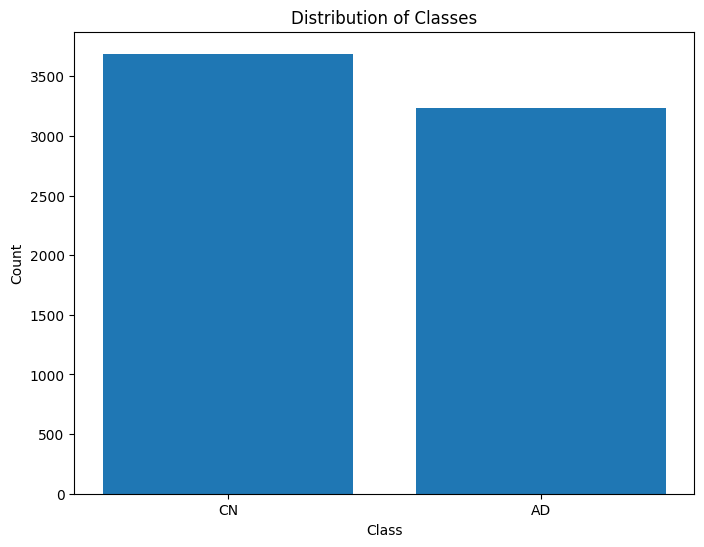

In [29]:

# 計算每個類別的樣本數量
p = np.array([[1, 0], [0, 1]])
count = [0,0]
class_names = ['CN', 'AD']
class_counts = [a ,c]

# 視覺化
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

In [27]:
#Performing over-sampling of the data, since the classes are imbalanced

import imblearn
smote = imblearn.over_sampling.SMOTE(random_state=42)
train_data, train_labels = smote.fit_resample(train_dataset.reshape(-1, 256 * 256 * 3), train_labels_dataset)
train_data = train_data.reshape(-1, 256,256, 3)
print(train_data.shape, train_labels.shape)


(6600, 256, 256, 3) (6600, 1)


In [28]:
from tensorflow.keras.utils import to_categorical
train_labels =to_categorical(train_labels)

In [64]:
train_data = train_dataset
train_labels = train_labels_dataset

In [65]:
test_data = train_dataset
test_labels = train_labels_dataset

### !!!!

In [56]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42,shuffle=True)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42,shuffle=True)

In [30]:
train_labels

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [31]:
from sklearn.utils import resample

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [35]:
# 加載已訓練的模型
models = [
    tf.keras.models.load_model('D:/bigwind/model_save_hippocampus/CN_AD_Binary_hippocampus_InceptionV3_EPOCH350'),
    tf.keras.models.load_model('D:/bigwind/model_save_hippocampus/CN_AD_Binary_hippocampus_MobileNet_EPOCH350'),
    tf.keras.models.load_model('D:/bigwind/model_save_hippocampus/CN_AD_Binary_hippocampus_ResNet50_EPOCH350'),
    tf.keras.models.load_model('D:/bigwind/model_save_hippocampus/CN_AD_Binary_hippocampus_VGG19_EPOCH350')
]


In [36]:
# 定義 Bagging 預測函數
def bagging_predict(models, X, n_samples):
    # 預測結果的列表
    predictions = []

    for model in models:
        # 從 X 中抽取隨機子樣本
        X_sample = resample(X, n_samples=n_samples, replace=True, stratify=test_labels)
        pred = model.predict(X_sample)
        predictions.append(pred)

    # 將所有模型的預測結果取平均
    predictions = np.array(predictions)
    #print('predictions:',predictions)
    avg_prediction = np.max(predictions, axis=0)
    #print('avg_predictions:',avg_prediction)
    return avg_prediction


In [70]:



# 使用集成模型進行預測
n_samples = len(test_data)  # 子樣本數目
y_pred = bagging_predict(models, test_data, n_samples)

# 將平均預測結果轉換為二進制標籤
#y_pred_binary = (y_pred > 0.5).astype(int)
y_pred_binary = np.argmax(y_pred, axis=1)
y_test_binary = np.argmax(test_labels, axis=1)




# 評估模型
accuracy = accuracy_score(y_test_binary, y_pred_binary)
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
class_report = classification_report(y_test_binary, y_pred_binary)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.49927849927849927
Confusion Matrix:
[[345 384]
 [310 347]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.47      0.50       729
           1       0.47      0.53      0.50       657

    accuracy                           0.50      1386
   macro avg       0.50      0.50      0.50      1386
weighted avg       0.50      0.50      0.50      1386



In [60]:
y_pred

array([[0.7039544 , 0.29636374],
       [0.46208197, 0.5361681 ],
       [0.5380324 , 0.46262893],
       ...,
       [0.62268674, 0.37871695],
       [0.7802683 , 0.21947378],
       [0.70545304, 0.29498532]], dtype=float32)

In [56]:
y_pred_binary

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [57]:
# y_pred 為 shape (N, 2)，需要轉換為 shape (N,)
y_pred_binary = np.argmax(y_pred, axis=1)

# 將 y_test 也轉換為 shape (N,)
y_test_binary = np.argmax(test_labels, axis=1)

In [58]:
y_pred_binary

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [59]:
y_test_binary

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

### !!!!!!!!!!!!!!!!!!!!!!!!!!!!

### Using the InceptionV3 model as a base model for the task

In [71]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import VotingClassifier

In [31]:
hippocampus_InceptionV3 =  tf.keras.models.load_model('D:/bigwind/model_save_ventricle/CN_AD_Binary_ventricle_InceptionV3_EPOCH200')
hippocampus_MobileNet  =  tf.keras.models.load_model('D:/bigwind/model_save_ventricle/CN_AD_Binary_ventricle_MobileNetV2_EPOCH200')
hippocampus_ResNet50   = tf.keras.models.load_model('D:/bigwind/model_save_ventricle/CN_AD_Binary_ventricle_ResNet50_EPOCH200')
hippocampus_VGG19  =  tf.keras.models.load_model('D:/bigwind/model_save_ventricle/CN_AD_Binary_ventricle_VGG19_EPOCH300')

In [32]:
hippocampus_InceptionV3._name = 'ventricle_InceptionV3'
hippocampus_MobileNet._name =  'ventricle_MobileNet'
hippocampus_ResNet50._name =   'ventricle_ResNet50'
hippocampus_VGG19._name = 'ventricle_VGG19'

In [36]:
# 獲取模型的所有層
model_layers_1 = hippocampus_InceptionV3.layers[:-14]  # 去除最後兩層
model_layers_2 = hippocampus_MobileNet.layers[:-14]
model_layers_3 = hippocampus_ResNet50.layers[:-14]
model_layers_4 = hippocampus_VGG19.layers[:-14]

# 創建新的模型
new_model_1 = tf.keras.Sequential(model_layers_1)
new_model_2 = tf.keras.Sequential(model_layers_2)
new_model_3 = tf.keras.Sequential(model_layers_3)
new_model_4 = tf.keras.Sequential(model_layers_4)

# 查看新模型結構
new_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
Total params: 21,802,784
Trainable params: 2,377,728
Non-trainable params: 19,425,056
_________________________________________________________________


In [37]:
new_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 512)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
Total params: 20,024,384
Trainable params: 0
Non-trainable params: 20,024,384
_________________________________________________________________


In [38]:
for layer in new_model_1.layers:
    layer.trainable=False

for layer in new_model_2.layers:
    layer.trainable=False

for layer in new_model_3.layers:
    layer.trainable=False

for layer in new_model_4.layers:
    layer.trainable=False

In [74]:
for layer in hippocampus_InceptionV3.layers:
    layer.trainable=False

for layer in hippocampus_MobileNet.layers:
    layer.trainable=False

for layer in hippocampus_ResNet50.layers:
    layer.trainable=False

for layer in hippocampus_VGG19.layers:
    layer.trainable=False


In [40]:
estimators = [
    ('hippocampus_InceptionV3', hippocampus_InceptionV3),
    ('hippocampus_MobileNet', hippocampus_MobileNet),
    ('hippocampus_ResNet50', hippocampus_ResNet50),
    ('hippocampus_VGG19', hippocampus_VGG19),
]

In [76]:
test_data.shape

(1386, 256, 256, 3)

In [39]:

inputs = tf.keras.Input(shape=(256, 256, 3))

pred_1 = new_model_1(inputs)
pred_2 = new_model_2(inputs)
pred_3 = new_model_3(inputs)
pred_4 = new_model_4(inputs)


concate = tf.keras.layers.concatenate([pred_1  , pred_2 ,pred_3 ,pred_4 ])

#x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(concate)

hidden1 = tf.keras.layers.Dropout(0.3)(x)
hidden2 = tf.keras.layers.Dense(64,activation='relu')(hidden1)
hidden3 = tf.keras.layers.Dropout(0.3)(hidden2)
hidden4 = tf.keras.layers.Dense(32,activation='relu')(hidden3)
hidden5 = tf.keras.layers.Dropout(0.3)(hidden4)
hidden6 = tf.keras.layers.Dense(16,activation='relu')(hidden5)
#hidden7 = tf.keras.layers.Dropout(0.3)(hidden6)

outputs = tf.keras.layers.Dense(2, activation='softmax')(hidden6)

model = tf.keras.Model(inputs=inputs, outputs=outputs , name='blending_model')


In [40]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        # 如果 lr 是一个 LearningRateSchedule，则需要计算当前的学习率
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"Epoch {epoch + 1}: Learning rate is {lr.numpy():.6f}")


learning_rate_logger = LearningRateLogger()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2,verbose=1)
CALLBACKS = [rop_callback,learning_rate_logger]

In [41]:

optimizer = model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50, batch_size=32,callbacks=CALLBACKS)

loss, accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

predictions = model.predict(test_data)

Epoch 1/50
131/131 [==============================] - 70s 395ms/step - loss: 0.7827 - accuracy: 0.6437 - val_loss: 0.6449 - val_accuracy: 0.7008
Epoch 1: Learning rate is 0.001000
Epoch 2/50
131/131 [==============================] - 43s 326ms/step - loss: 0.5997 - accuracy: 0.7673 - val_loss: 0.6789 - val_accuracy: 0.6721
Epoch 2: Learning rate is 0.001000
Epoch 3/50
131/131 [==============================] - 42s 322ms/step - loss: 0.5727 - accuracy: 0.7791 - val_loss: 0.6692 - val_accuracy: 0.6979

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 3: Learning rate is 0.000100
Epoch 4/50
131/131 [==============================] - 42s 322ms/step - loss: 0.4890 - accuracy: 0.7956 - val_loss: 0.6410 - val_accuracy: 0.6950
Epoch 4: Learning rate is 0.000100
Epoch 5/50
131/131 [==============================] - 42s 325ms/step - loss: 0.4673 - accuracy: 0.7936 - val_loss: 0.6495 - val_accuracy: 0.6922
Epoch 5: Learning rate is 0.000100
Epoch 6/50
131/131

In [42]:
#Saving the model for future use    #模型名稱 : 數據量_EPOCH_
save_path = 'D:/bigwind/model_save_ventricle/'
custom_inception_model_dir = save_path + "ventricle4_stacking_CNAD_"
model.save(custom_inception_model_dir, save_format='h5')
os.listdir(save_path)

d:\CONDA\envs\bigwind_3.7\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


['CN_AD_Binary_ventricle_InceptionV3_EPOCH200',
 'CN_AD_Binary_ventricle_MobileNetV2_EPOCH200',
 'CN_AD_Binary_ventricle_ResNet50_EPOCH200',
 'CN_AD_Binary_ventricle_VGG19_EPOCH300',
 'ventricle4_stacking_CNAD_']

In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

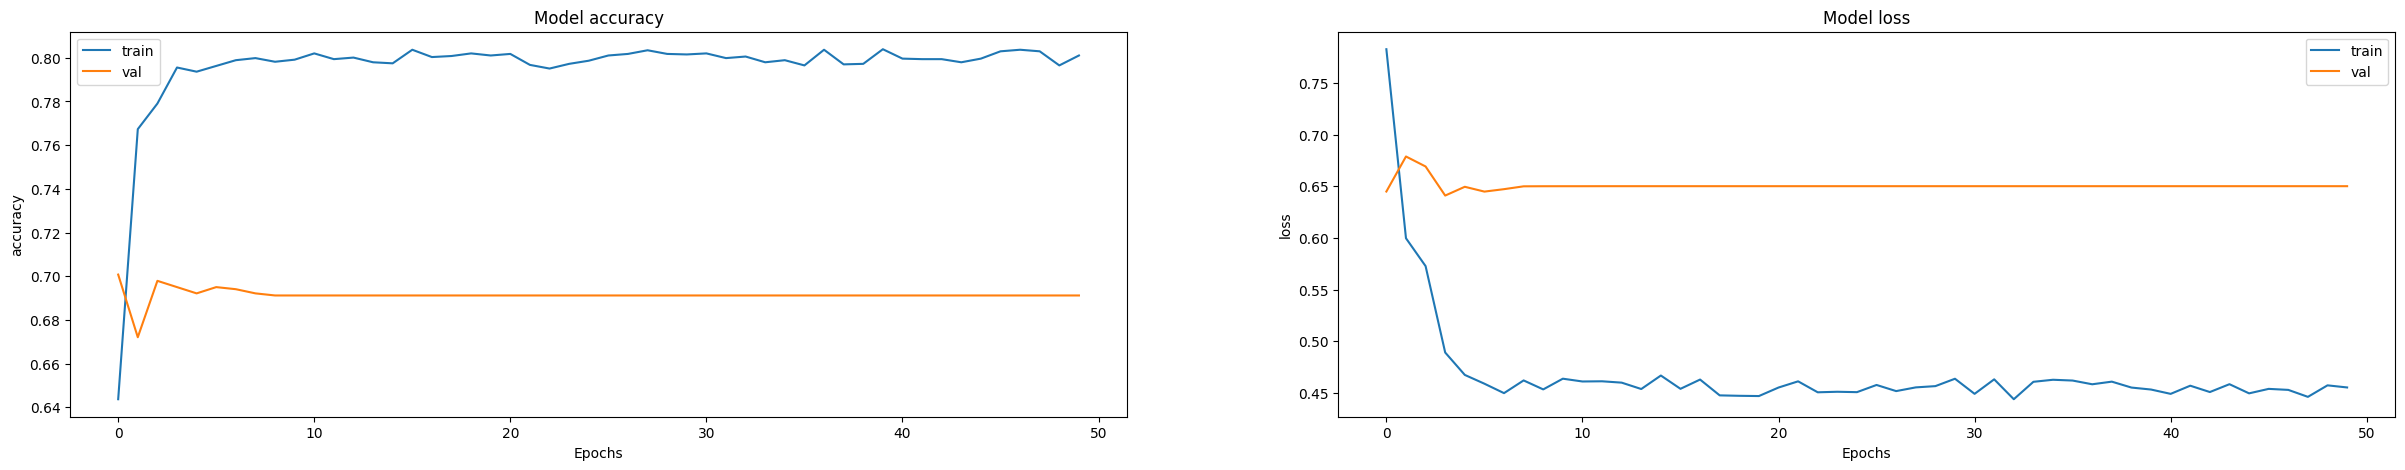

In [44]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 2, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [46]:
#Predicting the test data

pred_labels = model.predict(test_data)  

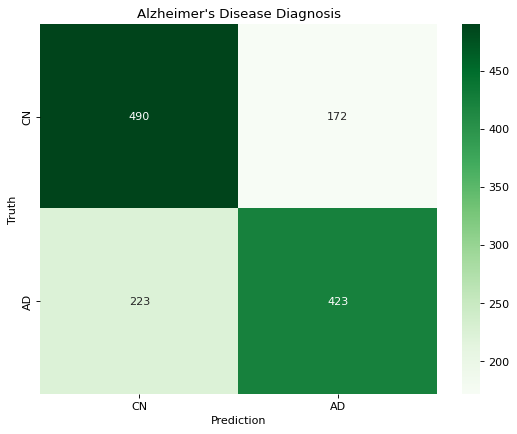

In [47]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [45]:
model.summary()

Model: "blending_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2048)         21802784    input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1280)         2257984     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 2048)         23587712    input_1[0][0]                    
_____________________________________________________________________________________

In [47]:
train_data.shape

(4224, 256, 256, 3)

In [46]:
train_labels.shape

(4224, 2)

### 使用加權平均做出最終總預測

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [41]:
hippocampus4  =  tf.keras.models.load_model('D:/bigwind/model_save_hippocampus/hippocampus4_stacking_CNAD_')

In [33]:
ventricle4 = tf.keras.models.load_model('D:/bigwind/model_save_ventricle/ventricle4_stacking_CNAD_')

In [34]:
pred_labels_ventricle = ventricle4.predict(test_data) 

In [66]:
pred_labels_hippocampus = hippocampus4.predict(test_data)

In [35]:
test_labels

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [43]:
pred_labels_hippocampus

array([[0.5948218 , 0.40517822],
       [0.30571625, 0.6942838 ],
       [0.8594113 , 0.14058872],
       ...,
       [0.7062313 , 0.2937687 ],
       [0.7749414 , 0.22505862],
       [0.7533175 , 0.24668252]], dtype=float32)

In [61]:
pred_labels_ventricle

array([[0.05679272, 0.94320726],
       [0.46774456, 0.5322554 ],
       [0.87163734, 0.12836263],
       ...,
       [0.17030211, 0.82969797],
       [0.95386845, 0.04613156],
       [0.8371364 , 0.1628636 ]], dtype=float32)

### 把預測值與標籤改成一維


In [36]:
test_labels_one = np.argmax(test_labels, axis=1)

In [67]:
pred_labels_hippocampus_one = np.argmax(pred_labels_hippocampus, axis=1)

In [37]:
pred_labels_ventricle_one = np.argmax(pred_labels_ventricle, axis=1)

### 先看看海馬體各自準確度

In [68]:
accuracy_hippocampus = accuracy_score(test_labels_one,pred_labels_hippocampus_one )  #海馬體
print(f'Accuracy: {accuracy_hippocampus}')

Accuracy: 0.6283333333333333


In [40]:
accuracy_ventricle = accuracy_score(test_labels_one,pred_labels_ventricle_one  )  #腦室

print(f'Accuracy: {accuracy_ventricle}')

Accuracy: 0.6141666666666666


### 做平均加總

In [69]:
overall_pred_labels = (0.2 * pred_labels_ventricle) + (0.8 * pred_labels_hippocampus)

In [70]:
overall_pred_labels

array([[0.392994  , 0.607006  ],
       [0.34927833, 0.65072167],
       [0.30820987, 0.69179016],
       ...,
       [0.79826355, 0.2017365 ],
       [0.65993   , 0.34007004],
       [0.33422104, 0.665779  ]], dtype=float32)

In [71]:
# 將加權平均後的預測結果轉換為最終的類別標籤
overall_pred_labels_classes = np.argmax(overall_pred_labels, axis=1)

In [72]:
accuracy = accuracy_score(test_labels_one, overall_pred_labels_classes)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6291666666666667


In [73]:
conf_matrix = confusion_matrix(test_labels_one, overall_pred_labels_classes)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[367 233]
 [212 388]]
